In [1]:
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme="onedork", context="notebook", ticks=True, grid=True)

import numpy as np
import itertools
import h5py
import os
import sys
import glob

import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import pandas as pd
import tikzplotlib  

# from tqdm import tqdm
from tqdm.notebook import tqdm_notebook as tqdm

import helper.circular
import fastpli.io
import fastpli.tools
import fastpli.objects
import fastpli.analysis

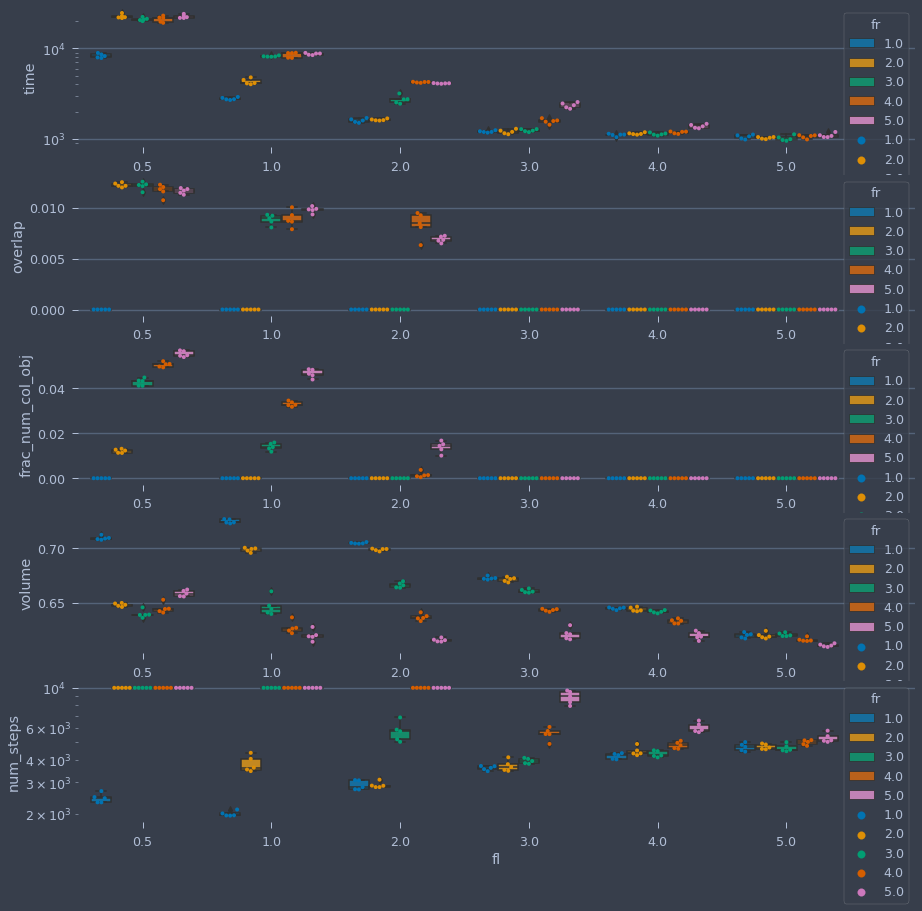

In [4]:
df = pd.read_pickle("output/cube_stat/cube_stat.pkl")
df = df[df.state == "solved"]
df = df[df.omega == 90.0]
df = df[df.psi == 0.5]
df = df[df.fl <= 6]
df['volume'] = df.count_elements.map(
    lambda x: np.sum(x[1:])) / df.count_elements.map(np.sum)
df['frac_num_col_obj'] = df.num_col_obj / df.num_obj

# palette = "husl"
palette = "colorblind"
# colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
# palette = sns.xkcd_palette(colors)

ys = ["time", "overlap", "frac_num_col_obj", "volume", "num_steps"]
# ys = ["time", "overlap", "num_col_obj", "num_obj", "num_steps", "volume"]
f, ax = plt.subplots(len(ys), 1, figsize=(15, 15))
sns.despine(f, left=True, bottom=True)

for i, y in enumerate(ys):
    sns.boxplot(x="fl", y=y, hue="fr", palette=palette, data=df, ax=ax[i])
    sns.swarmplot(
        x="fl",
        y=y,
        hue="fr",
        palette=palette,
        data=df,
        size=4,
        # color=".2",
        dodge=True,
        ax=ax[i])
    ax[i].set_xlim(-0.5, 6)
    if y in ["time", "num_steps"]:
        ax[i].set(yscale="log")
        
        
# tikzplotlib.save("test.tex")

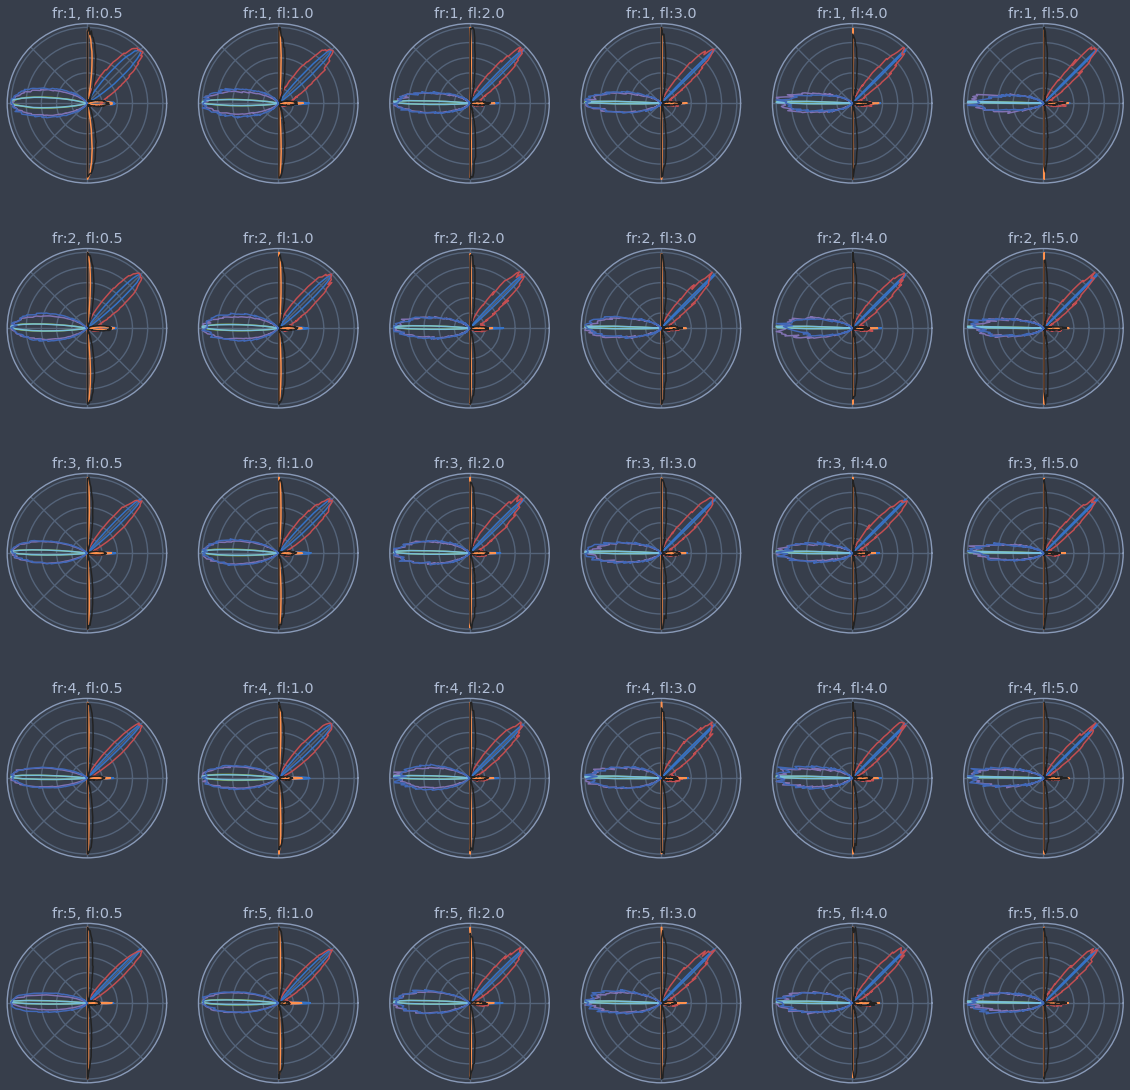

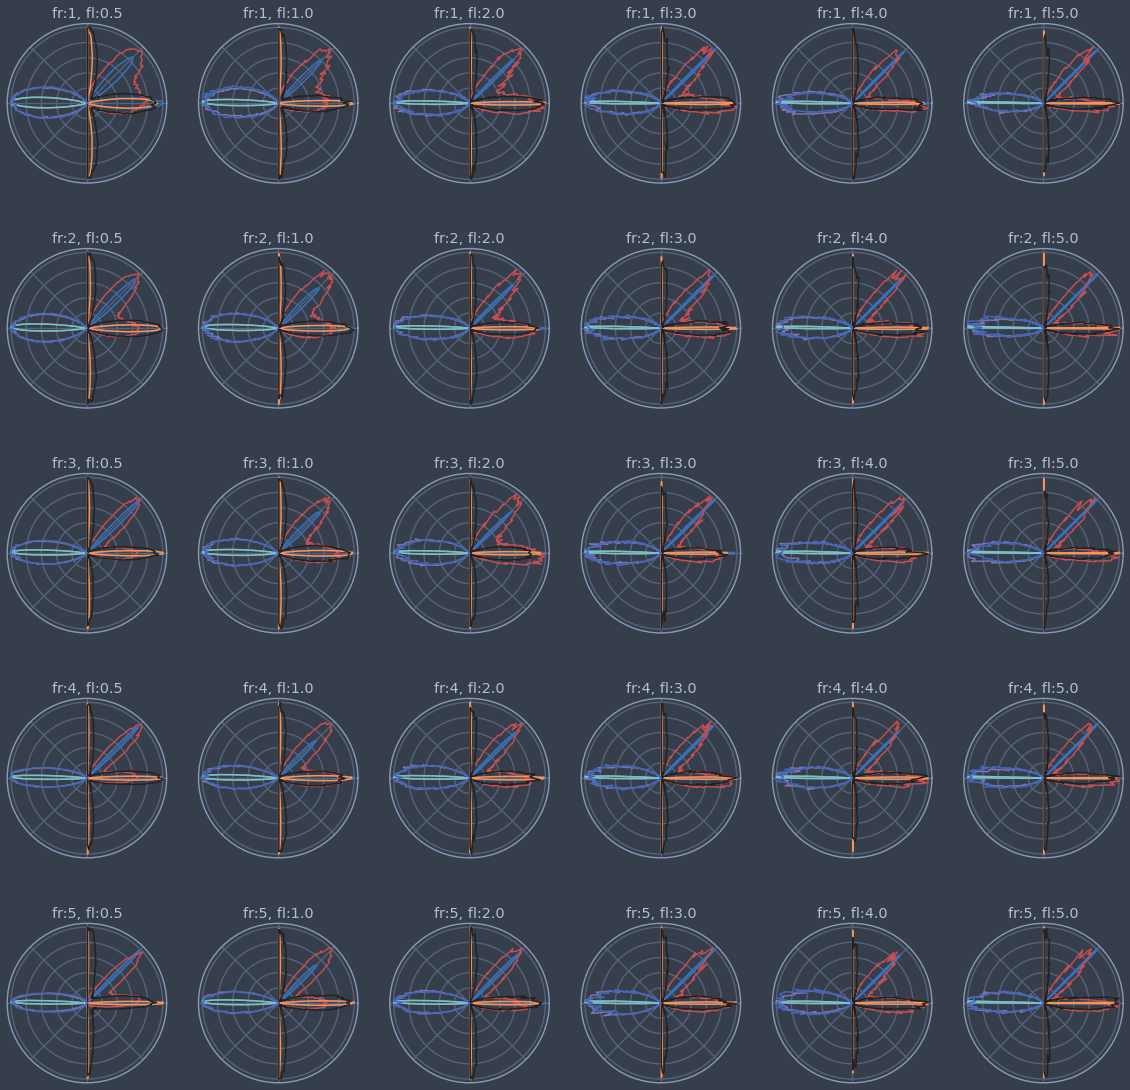

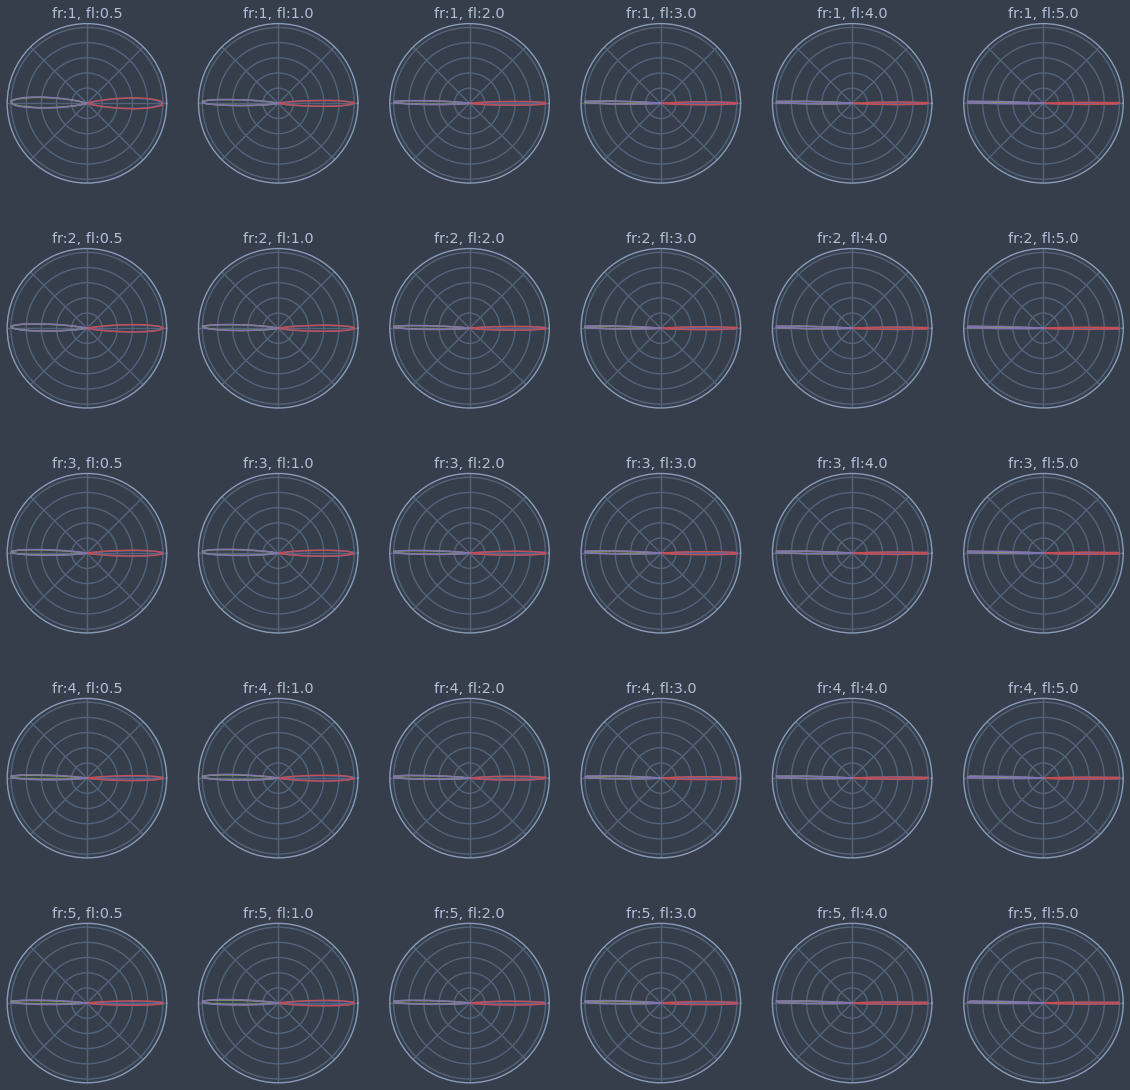

In [3]:
df = pd.read_pickle("output/cube_stat/cube_stat.pkl")
hist_bin = lambda n: np.linspace(0, np.pi, n + 1, endpoint=True)

for psi in sorted(df.psi.unique()):
    fig, axs = plt.subplots(len(df.fr.unique()),
                            len(df.fl.unique()),
                            subplot_kw={'projection': 'polar'},
                            figsize=(20, 20))
    axs = np.atleast_2d(axs)

    for i, fr in enumerate(sorted(df[df.psi == psi].fr.unique())):
        for j, fl in enumerate(sorted(df[df.psi == psi].fl.unique())):
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i, j].set_title(f"fr:{fr:.0f}, fl:{fl:.1f}")

    for omega in sorted(df.omega.unique()):
        df_ = df[(df.omega == omega) & (df.psi == psi)]
        if len(df_) == 0:
            continue
        for i, fr in enumerate(sorted(df_.fr.unique())):
            for j, fl in enumerate(sorted(df_[df_.fr == fr].fl.unique())):
                for phase, color in [("init", "g"), ("solved", "r")]:
                    sub = (df_.fl == fl) & (df_.fr == fr) & (
                        df_.state == phase) & (df_.n == 0.0) & (df_.state == phase)

                    if len(df_[sub]) != 1:
                        print("fooo", fl, fr, phase)

#                     phi = df_[sub].explode("phi").phi.to_numpy(float)
#                     theta = df_[sub].explode("theta").theta.to_numpy(float)
#                     theta[phi > np.pi] = np.pi - theta[phi > np.pi]
#                     phi = helper.circular.remap(phi, np.pi, 0)

#                     h, x = np.histogram(phi, hist_bin(180), density=True)
                    h = df_[sub].explode(
                        "phi_h").phi_h.to_numpy(float)
                    x = df_[sub].explode(
                        "phi_x").phi_x.to_numpy(float)
                    
#                     print(df_[sub])
                    x = x[:-1] + (x[1] - x[0]) / 2
                    x = np.append(np.concatenate((x, x + np.pi), axis=0), x[0])
                    h = np.append(np.concatenate((h, h), axis=0), h[0])
                    h = h / np.max(h)
                    h = h[(x > np.pi * 3 / 2) | (x < np.pi / 2)]
                    x = x[(x > np.pi * 3 / 2) | (x < np.pi / 2)]
                    axs[i, j].plot(x, h)

                    #                     h, x = np.histogram(theta, hist_bin(180), density=True)
                    h = df_[sub].explode(
                        "theta_h").theta_h.to_numpy(float)
                    x = df_[sub].explode(
                        "theta_x").theta_x.to_numpy(float)
                    x = np.pi - (np.pi / 2 - x[:-1] + (x[1] - x[0]) / 2
                                 )  # np/2 for incl, - for plot
                    h = h / np.max(h)
                    h = h[x > np.pi / 2]
                    x = x[x > np.pi / 2]
                    axs[i, j].plot(x, h)